In [1]:
import numpy as np
import matplotlib.pyplot as plt
from schmidt_spike_removal import schmidt_spike_removal
from homomorphic_envelope_with_hilbert import homomorphic_envelope_with_hilbert
from get_PSD_feature_Springer_HMM import get_PSD_feature_Springer_HMM

In [2]:
audio = np.loadtxt('train/train_recording_1.txt')
psd = get_PSD_feature_Springer_HMM(audio, sampling_frequency=1000)

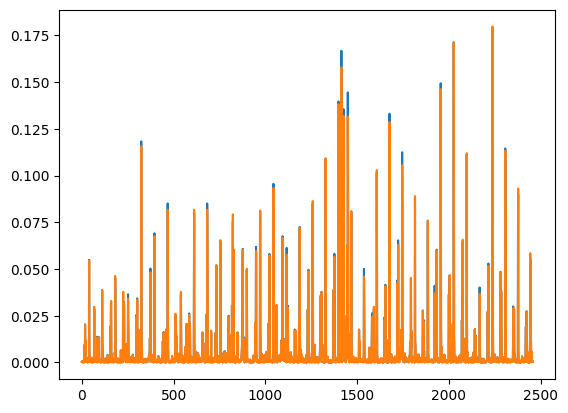

In [5]:
audio_matlab = np.loadtxt('testing_functions/psd_matlab.txt')

plt.figure()
plt.plot(psd)
plt.plot(audio_matlab)
plt.show()

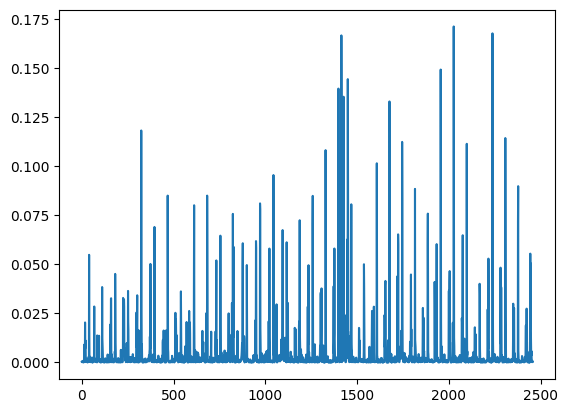

In [4]:
plt.plot(psd)